In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [12]:
def sin_w(N):
    n = np.arange(N)
    return np.sin(np.pi*(n+.5)/N)

In [14]:
fs = 48000

f0 = 440
# f1 = 554
# f2 = 660
# f3 = 880
# f4 = 4400
# f5 = 8800

A0 = 0.6
# A1 = 0.55
# A2 = 0.55
# A3 = 0.15
# A4 = 0.1
# A5 = 0.05

# n variando de 0 a 2048
n = [i for i in range(N)]

In [15]:
x = A0*np.cos(2*(np.pi)*f0/fs, n)
plt.figure(figsize=(20,10))
plt.plot(n, x)
plt.ylabel('x[n]')
plt.xlabel('n')
plt.show()

TypeError: return arrays must be of ArrayType

In [ ]:
X = np.fft.fftshift(np.fft.fft(x, n=N))
plt.figure(figsize=(20,10))
plt.plot(X)
plt.ylabel('X[n]')
plt.xlabel('k)
plt.show()

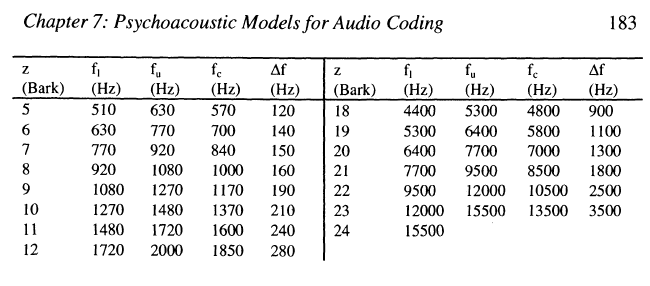

In [ ]:
def bit_allocation_greedy(K_p, P, N_b, xmax_b):
    avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2))/K_p
    buffer = (P/K_p) + 0.5 * np.array(N_b) * np.log2(xmax_b ** 2) - avg
    if np.any(buffer < 0):
        N_b = N_b[np.nonzero(buffer > 0)[0]]
        xmax_b = xmax_b[np.nonzero(buffer > 0)[0]]
        K_p = len(xmax_b)
        return bit_allocation_greedy(K_p, P, N_b, xmax_b)
    return buffer

In [13]:
#bark scale
def bark(f):
    return 13*np.arctan(.76*f/1000)+3.5*np.arctan((f/7500)**2)

In [16]:
def get_subband_index(f):
    return int(bark(f))

In [18]:
get_subband_index(3700)

16

In [9]:
N = 2048
fk = Fs*k/N

1.25188872417794

### 6.12 Item 1

In [3]:
F_s = 48000
n = np.arange(F_s+1)
f0 = 1000
x = np.sin(2*np.pi*f0*n/F_s)
N = 2048
N_fft = N*8

w = sin_w(N)
bw = 3*F_s/N

x_w = x[0:N]*w
print(x_w.shape[-1])

X_w = np.fft.fftshift(np.fft.fft(x_w,n=int(N_fft)))
omega = np.fft.fftshift(np.fft.fftfreq(X_w.shape[-1]))
print(f'Normalized area: {np.sum(np.square(np.abs(X_w[:int(N_fft/2)]))/(N**2*8/8))}')
max_norm_freq_comp = (np.max(np.square(np.abs(X_w))/(N**2/8)))
amp_3dB_arg = np.argmin(np.abs(np.square(np.abs(X_w))/(N**2/8)-max_norm_freq_comp/2))

2048
Normalized area: 1.000000269341257


### 6.12 Item 2

In [4]:
A = np.array([.6, .55, .55, .15, .1, .05])
freq = np.array([440, 554, 660, 880, 4400, 8800])
w = sin_w(N)
x = np.zeros(n.shape[-1])
for i in range(A.shape[-1]): x += A[i]*np.sin(2*np.pi*freq[i]*n/F_s)
x_w = x[0:N]*w

N_fft = N
bw = 3*F_s/N

def get_idx(f_array, f):
    return np.argmin(np.abs(f_array-f))

def spl(x, w, f_arr, N_fft, F_s, E0=10**(-9.6)):
    #print(f,N_fft,F_s)
    N = w.shape[-1]
    bw_factor = N_fft/(2*N)
    x_w = x[:N]*w
    X_w = np.fft.fftshift(np.fft.fft(x_w,n=N_fft))
    omega = np.fft.fftshift(np.fft.fftfreq(N_fft))
    idx = np.zeros(f_arr.shape[-1], dtype=int)
    for i in range(f_arr.shape[-1]):
        idx[i] = get_idx(omega*F_s,f_arr[i])
    F = np.array([10*np.log10(np.sum(np.abs(X_w[idx[i]-int(np.ceil(3*bw_factor)):idx[i]+int(np.ceil(3*bw_factor))])**2)/(N*N_fft/8)/E0) for i in range(f_arr.shape[-1])])
    return F


#reference amplitude
E0 = 10**(-96/10)

X_w = np.fft.fftshift(np.fft.fft(x_w,n=N_fft))
omega = np.fft.fftshift(np.fft.fftfreq(X_w.shape[-1]))

F = spl(x,w,freq,N_fft,F_s)

#Threshold in quiet (dB)
f = np.linspace(20, 20000, 1000)
t = 3.64*(f/1000)**(-.8)-6.5*np.exp(-.6*(f/1000-3.3)**2)+10**(-3)*(f/1000)**4

In [6]:
#number of steps N in z
N_z = 1000

#bark scale
def bark(f):
    return 13*np.arctan(.76*f/1000)+3.5*np.arctan((f/7500)**2)

#spreading of masking
def spreading_f(dz,L):
    return (-27+.37*np.max(L-40,0)*np.heaviside(dz,1))*np.abs(dz)

def delta_tone_masking_noise(z):
    return 14.5+z#dB -> in text it's 14.5 but in the end of the chapter, to generate the chart, it was used delta=15 dB

#not used
def sum1(arr, alpha):
    return np.power(np.sum(np.power(arr,alpha)),1/alpha)

#max
def sum2(arr):
    return np.max(arr)

def calc_SMR(spl, z, mask, N=N_z):
    z_values = np.linspace(0,25,N)
    mask_arg = np.argmin(np.abs(z_values-z))
    return spl-mask[mask_arg]

def masking_model(z,L,N):
    mask = L+spreading_f(np.linspace(-z,25-z,N),L)-delta_tone_masking_noise(z)
    return mask

136.61561621679027
SMR(f=440): 18.79030928497839
SMR(f=554): 19.744456904230333
SMR(f=660): 20.652668102727006
SMR(f=880): 22.31100204548875
SMR(f=4400): 32.57873561235188
SMR(f=8800): 36.39906371379563


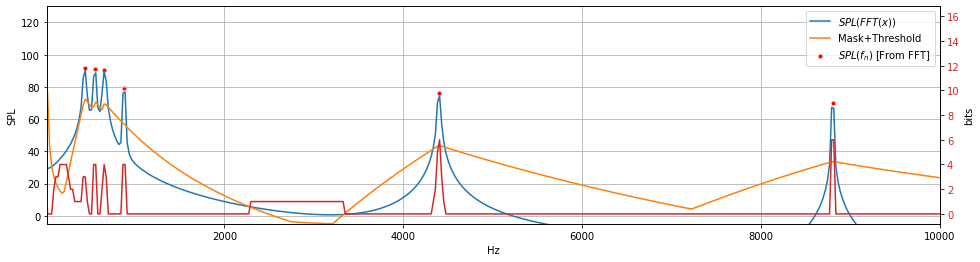

In [7]:
masks = []
for i in range(A.shape[-1]):
    masks.append(masking_model(bark(freq[i]),F[i],N_z)) #each frequency mask
#
# print(list(masks)[1])
masks = np.matrix(masks)#= np.concatenate(list(masks),0)
mask = np.zeros(masks.shape[-1])
for i in range(masks.shape[-1]):
    mask[i] = sum2(masks[:,i]) #combination of all masks

spl_fft_x = 10*np.log10((np.abs(X_w)**2/(N*N_fft/8))/E0)

#print(bark(f).shape[-1])
#print(t.shape[-1])

z_values = np.linspace(0,25,N_z)
mask_interp_z = interp1d(z_values,mask) #interpolation of mask for z values
threshold_interp_z = interp1d(bark(f),t) #interpolation of threshold for z values
#spl_fft_x_interp_z = interp1d(bark(omega*F_s), spl_fft_x, kind='quadratic')
omega_in_bark = bark(omega*F_s) #omegas of FFT in bark values

bits = np.zeros(N)
final_mask = np.zeros(N)
#print(z_values[:2])
print(threshold_interp_z(24.5))

for i in range(N):
    #combine threshold in silence with mask
    if omega_in_bark[i]>=.2 and omega_in_bark[i]<=24.575: final_mask[i] = sum2((threshold_interp_z(omega_in_bark[i]), mask_interp_z(omega_in_bark[i])))
    #bits of each frequency component
    bits[i] = max(np.ceil((spl_fft_x[i]-final_mask[i])/6),0) 

for i in range(freq.shape[-1]):
    print(f'SMR(f={freq[i]}): {calc_SMR(F[i],bark(freq[i]),mask)}')

fig, axs = plt.subplots(1, figsize=(16,4))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axs2 = axs.twinx()
axs2.set_ylabel('bits')
color='tab:red'
#axs.plot(omega_in_bark,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.plot(omega*F_s,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.set_xlim(20,10000)
#axs.set_xlim(0.2,24)
axs.scatter(freq,F, c='r', marker='.', label=r'$SPL(f_n)$ [From FFT]')
#axs.plot(omega_in_bark,final_mask, label='Mask+Threshold')
#axs2.plot(omega_in_bark, bits, label='bits', color=color)
axs.plot(omega*F_s,final_mask, label='Mask+Threshold')
axs2.plot(omega*F_s, bits, label='bits', color=color)
axs.set_ylim(-5,130)
axs.grid()
#axs.set_xlabel('Barks')
axs.set_xlabel('Hz')
axs.set_ylabel('SPL')
axs.legend()
axs2.tick_params(axis='y', labelcolor=color)

In [8]:
#print(bark(f))
#print(t)
#print(bark(20))
#print(z_values)
print(max(0,1))

threshold_interp_z = interp1d(bark(f),t, kind='quadratic')

1
